# Labeller

In [2]:
import numpy as np


def driver(signal_df, n_components=3, signal_column='Open'):
    # iterate over unique days in the df
    dates = signal_df.Date.unique()
    label_arr = np.zeros((signal_df.shape[0], 2))
    label_arr[:, 0] = signal_df.EpochTime.values
    for d_idx in range(len(dates)):
        # filter on this date
        this_date = dates[d_idx]
        insert_idx = (signal_df['Date'] == this_date)
        signal = signal_df[signal_column].loc[insert_idx].values

        # compute search space for signal
        search_space = compute_search_space(signal)

        # compute growth/decay function and coefficients
        exp_func, _ = compute_growth_coeff(signal, search_space)

        # remove behavior from signal
        no_growth_signal = signal - exp_func

        # compute FFT on growth-less signal
        fft_signal, _ = compute_fft(no_growth_signal, n_components)

        # combine for final signal
        final_signal = exp_func + fft_signal

        # compute differentials of the clean signal to obtain our labels
        clean_signal_diff = np.gradient(final_signal)

        # all points with a positive gradient value are labelled 1
        label_slice = np.zeros((signal.shape[0], 2))
        label_slice[:, 0] = signal_df.EpochTime.values[insert_idx]
        label_slice[clean_signal_diff > 0, 1] = 1
        label_arr[insert_idx] = label_slice

    label_df = pd.DataFrame(label_arr, columns=['EpochTime', 'Label'])
    return label_df


def compute_search_space(signal):
    if signal[-1] > signal[0]:
        # if signal is increasing
        A_values = np.arange(.1, 10.1, .1)
    elif signal[-1] > signal[0]:
        # if signal is decreasing
        A_values = np.arange(-10, 0, .1)
    else:
        # if signal is flat
        A_values = np.arange(-1, 1.1, .1)

    B_values = np.arange(.1, 3.1, .1)

    return np.array(np.meshgrid(A_values, B_values)).T.reshape(-1, 2)


def compute_growth_coeff(signal, search_space):
    # Step 1: Convert the Search Space into a Function Space  ###
    t = np.arange(0, signal.shape[0]).reshape(-1, 1)
    # stack time column vectors into a matrix that's len(time values) x len(combos)
    func_space = np.repeat(t, search_space.shape[0], axis=1)
    # raise time values to B powers in search space
    func_space = func_space ** search_space[:, 1]
    # scale functions by A coefficients
    func_space = search_space[:, 0] * func_space
    # add C term
    func_space += signal[0]

    # Step 2: Compute Error Space
    signal_mat = np.repeat(signal.reshape(-1, 1), search_space.shape[0], axis=1)
    error_space = np.sum(np.abs(signal_mat - func_space), axis=0)

    # Step 3: Find Combo in Search Space w/ Lowest Error
    best_idx = np.argmin(error_space)
    best_combo = search_space[best_idx]
    best_func = func_space[:, best_idx]

    return best_func, [best_combo[0], best_combo[1], signal[0]]


def compute_fft(signal, n_components=8):
    # compute FFT on signal
    n = signal.shape[0]  # get length of signal
    fhat = np.fft.fft(signal, n)  # compute FFT on noisy data
    PSD = fhat * np.conj(fhat) / n  # power spectral density -- multiply complex term by its conjugate and divide by n

    # compute values from FFT
    freq = (1 / n) * np.arange(n)  # frequency from full FFT
    amp = 2 / n * np.abs(fhat)  # amplitude from full FFT
    phase_shift = np.angle(fhat)  # phase shift from full FFT

    # down-sample the computed values from the full FFT
    L = np.arange(1, np.floor(n / 2), dtype='int')
    PSD_reduced = PSD[L]
    freq_reduced = freq[L]
    amp_reduced = amp[L]
    phase_shift_reduced = phase_shift[L]

    # get Fourier Series values
    min_PSD = np.sort(PSD_reduced)[-n_components]
    keep_idx_reduced = PSD_reduced > min_PSD
    freq_clean = freq_reduced[keep_idx_reduced]
    amp_clean = amp_reduced[keep_idx_reduced]
    phase_shift_clean = phase_shift_reduced[keep_idx_reduced]

    # compute inverse FFT for Clean Signal
    keep_idx_full = PSD > min_PSD
    fhat_clean = fhat * keep_idx_full
    fft_clean_signal = np.real(np.fft.ifft(fhat_clean))

    return fft_clean_signal, [amp_clean, freq_clean, phase_shift_clean]



# Plotting

In [3]:
import matplotlib.pyplot as plt
import numpy as np


def plot_label_over_signal(signal_df, label_df, signal_column='Open'):
    # set initial variables
    colors = {'0': 'red', '1': 'green'}
    t = np.arange(signal_df.shape[0])
    classes = label_df['Label'].unique().astype(int)

    # create plot and plot raw signal
    plt.figure()
    plt.title(f'{signal_df.Date.values[0]} - {signal_df.Date.values[-1]}')
    plt.plot(t, signal_df[signal_column].values)

    # plot label values over the signal
    for c_idx in classes:
        # filter on class values
        label_df_slice = label_df.loc[label_df['Label'].values == classes[int(c_idx)]]
        # plot
        plot_idx = np.in1d(signal_df.EpochTime.values, label_df_slice.EpochTime.values)
        plt.scatter(t[plot_idx],
                    signal_df[signal_column].values[plot_idx],
                    color=colors[str(classes[int(c_idx)])],
                    alpha=.5)

    return plt

# Driver

/var/folders/d4/gzxkzs0j3l7b25wvq8qxmj_80000gn/T/ipykernel_16254/4039924261.py:21: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  plot_idx = np.in1d(signal_df.EpochTime.values, label_df_slice.EpochTime.values)


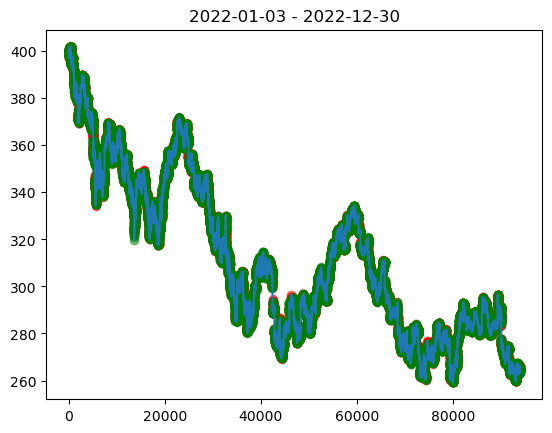

In [4]:
import pandas as pd

df = pd.read_csv('../data/qqq_2022.csv')
sig_col = 'Close'
raw_signal_df = df[['EpochTime', 'Date', sig_col]]  # .loc[df.Date.values == df.Date.unique()[1]]

# component analysis test
c_num = 20
label_df = driver(signal_df=raw_signal_df, n_components=c_num, signal_column=sig_col)
plt = plot_label_over_signal(raw_signal_df, label_df=label_df, signal_column=sig_col)
plt.show()

# ARIMA 1
uses this example: https://analyticsindiamag.com/ai-trends/quick-way-to-find-p-d-and-q-values-for-arima/

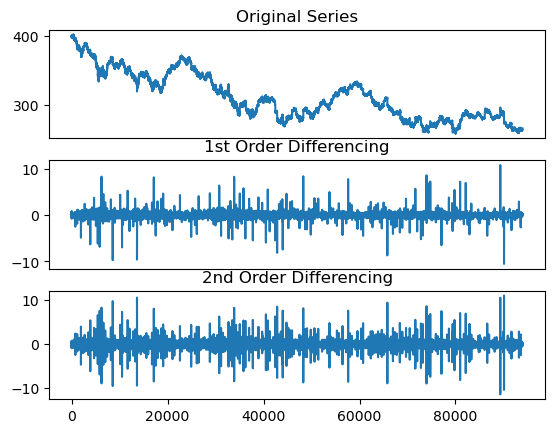

In [5]:
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(raw_signal_df[[sig_col]])
ax1.set_title('Original Series')
ax1.axes.xaxis.set_visible(False)

# 1st Differencing
ax2.plot(raw_signal_df[[sig_col]].diff())
ax2.set_title('1st Order Differencing')
ax2.axes.xaxis.set_visible(False)

# 2nd Differencing
ax3.plot(raw_signal_df[[sig_col]].diff().diff())
ax3.set_title('2nd Order Differencing')
plt.show()

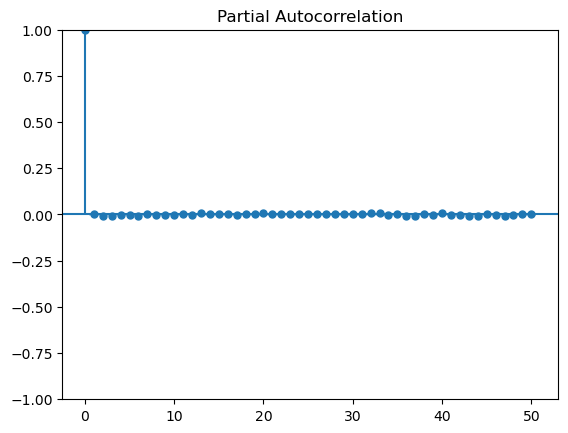

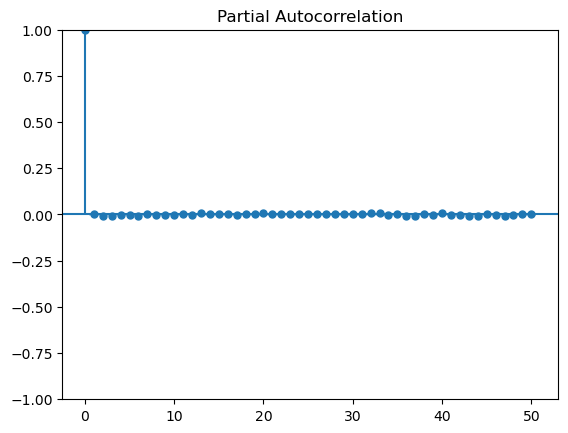

In [6]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(raw_signal_df[[sig_col]].diff().dropna())

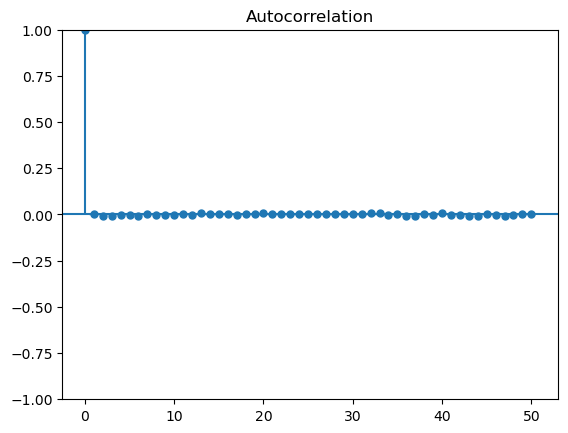

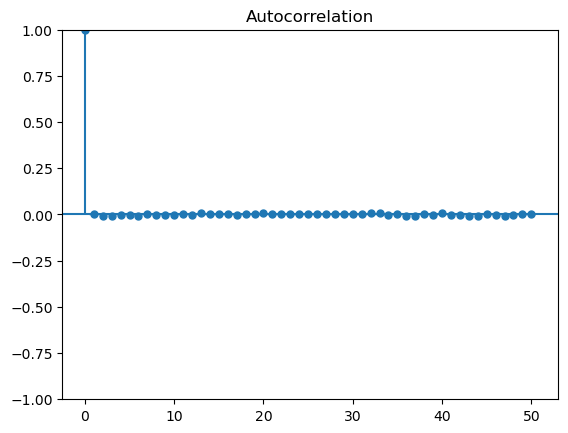

In [7]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(raw_signal_df[[sig_col]].diff().dropna())

In [8]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split

In [9]:
train_size = int(len(raw_signal_df) * 0.8)
train, test = raw_signal_df.iloc[:train_size], raw_signal_df.iloc[train_size:]
# print(len(train))
# print(len(test))

In [39]:
# Fit ARIMA model
# order contains (p,d,q) where:
#   p = how far back to look to help predict price
#   d = finds the difference between consecutive timestamps
#   q = size of the moving average window
p = 1
d = 1
q = 1
model = ARIMA(train[[sig_col]], order=(p,d,q))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                75184
Model:                 ARIMA(0, 1, 0)   Log Likelihood              -17985.815
Date:                Mon, 03 Mar 2025   AIC                          35973.629
Time:                        17:50:47   BIC                          35982.857
Sample:                             0   HQIC                         35976.466
                              - 75184                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0945   5.76e-05   1639.804      0.000       0.094       0.095
===================================================================================
Ljung-Box (L1) (Q):                   3.16   Jarque-Bera (JB):          62334840.97
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):               0.61   Skew:                            -0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                       144.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [11]:
# from statsmodels.graphics.tsaplots import plot_predict
# plot_predict(model_fit, dynamic=False)
# plt.show()

In [12]:
# model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

In [26]:
def diff_inv(series_diff, first_value):
    series_inverted = np.r_[first_value,series_diff].cumsum().astype('float64')
    return series_inverted

In [21]:
test[[sig_col]].to_numpy()[0]
train[[sig_col]].to_numpy()
test[[sig_col]].iloc[0]

Close    273.209991
Name: 75184, dtype: float64

In [32]:
# Forecast
forecast = model_fit.forecast(steps=len(test))
# forecast_dediff = diff_inv(forecast, test[[sig_col]].to_numpy()[0])
x, x_diff = test[sig_col].iloc[0], forecast.iloc[1:]
forecast_dd = np.r_[x, x_diff].cumsum().astype(int)



# forecast
forecast_dd

array([    273,     546,     819, ..., 4865732, 4865976, 4866221],
      shape=(18797,))

In [23]:
test[sig_col]

75184    273.209991
75185    273.239990
75186    272.970001
75187    273.100006
75188    273.220001
            ...    
93976    265.950012
93977    266.105011
93978    266.140106
93979    266.250000
93980    266.334991
Name: Close, Length: 18797, dtype: float64

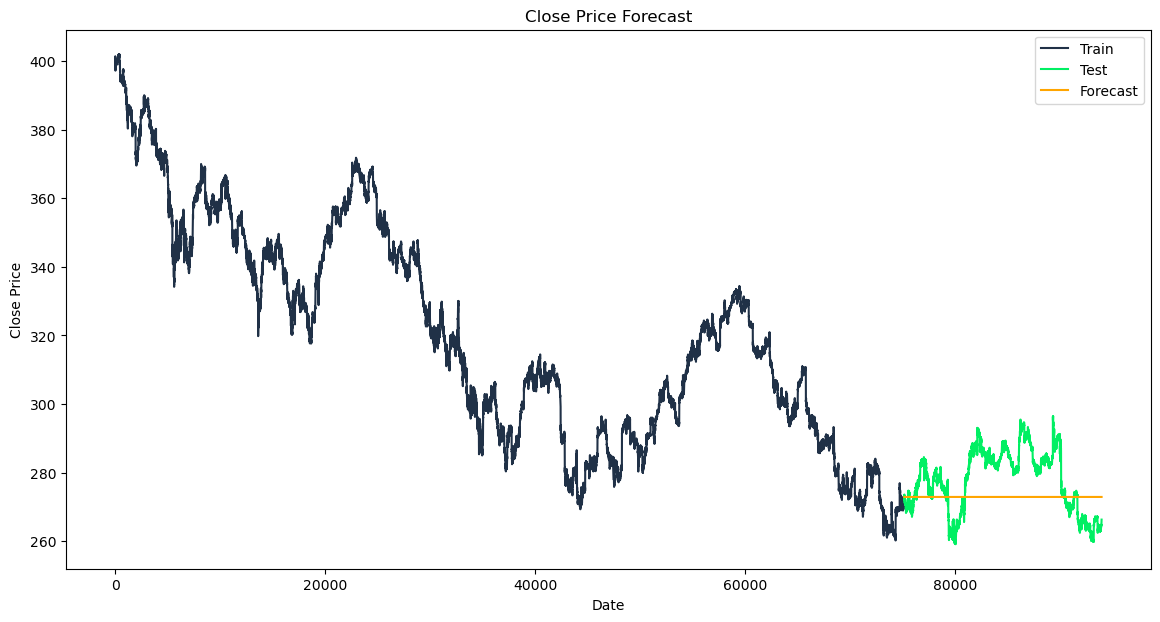

RMSE: 10.2617


In [40]:
# Forecast
forecast = model_fit.forecast(steps=len(test))

# Plot the results with specified colors
plt.figure(figsize=(14,7))
plt.plot(train.index, train[sig_col], label='Train', color='#203147')
plt.plot(test.index, test[sig_col], label='Test', color='#01ef63')
plt.plot(test.index, forecast, label='Forecast', color='orange')
plt.title(f'{sig_col} Price Forecast')
plt.xlabel('Date')
plt.ylabel(f'{sig_col} Price')
plt.legend()
plt.show()


forecast_vals = forecast[:len(test)]
test_vals = test[sig_col][:len(forecast)]

# Calculate RMSE
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test_vals, forecast))
print(f"RMSE: {rmse:.4f}")

In [15]:
forecast

75184    272.940367
75185    272.940354
75186    272.940355
75187    272.940355
75188    272.940355
            ...    
93976    272.940355
93977    272.940355
93978    272.940355
93979    272.940355
93980    272.940355
Name: predicted_mean, Length: 18797, dtype: float64

In [147]:
test['Forecast'] = forecast
test

/var/folders/d4/gzxkzs0j3l7b25wvq8qxmj_80000gn/T/ipykernel_47500/1389005052.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Forecast'] = forecast


,EpochTime,Date,Close,Forecast
75184,1.666189e+09,2022-10-19,273.209991,272.932090
75185,1.666189e+09,2022-10-19,273.239990,272.926917
75186,1.666190e+09,2022-10-19,272.970001,272.925311
75187,1.666190e+09,2022-10-19,273.100006,272.921347
75188,1.666190e+09,2022-10-19,273.220001,272.917520
...,...,...,...,...
93976,1.672434e+09,2022-12-30,265.950012,272.917770
93977,1.672434e+09,2022-12-30,266.105011,272.917770
93978,1.672434e+09,2022-12-30,266.140106,272.917770
93979,1.672434e+09,2022-12-30,266.250000,272.917770


# ARIMA 2
uses this example: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

18797


/opt/homebrew/anaconda3/envs/info629/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/anaconda3/envs/info629/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


epoch=0.000000, predicted=272.934175, expected=272.934175
epoch=1.000000, predicted=272.929731, expected=272.929731
epoch=2.000000, predicted=272.926748, expected=272.926748
epoch=3.000000, predicted=272.924006, expected=272.924006
epoch=4.000000, predicted=272.923657, expected=272.923657
epoch=5.000000, predicted=272.923732, expected=272.923732
epoch=6.000000, predicted=272.923784, expected=272.923784
epoch=7.000000, predicted=272.923812, expected=272.923812
epoch=8.000000, predicted=272.923828, expected=272.923828
epoch=9.000000, predicted=272.923829, expected=272.923829
epoch=10.000000, predicted=272.923828, expected=272.923828
epoch=11.000000, predicted=272.923828, expected=272.923828
epoch=12.000000, predicted=272.923827, expected=272.923827
epoch=13.000000, predicted=272.923827, expected=272.923827
epoch=14.000000, predicted=272.923827, expected=272.923827
epoch=15.000000, predicted=272.923827, expected=272.923827
epoch=16.000000, predicted=272.923827, expected=272.923827
epoch=1

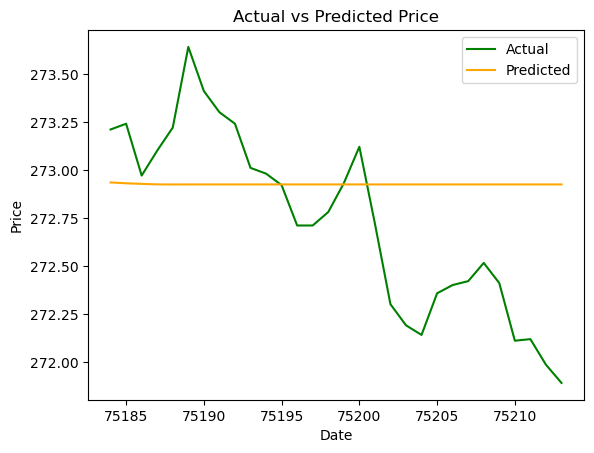

In [62]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

history = [x for x in train[[sig_col]].values]
predictions = list()
test_vals = test[[sig_col]].values

print(len(test))
r = 30

# walk-forward validation
# for t in range(len(test)):
for t in range(r):
    model = ARIMA(history, order=(5,1,2))
    model_fit = model.fit(method='statespace')
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
	# obs = test_vals[t]
    obs = yhat
    # history.append(obs)
    history.append([yhat])
    print('epoch=%f, predicted=%f, expected=%f' % (t, yhat, obs))
# evaluate forecasts
# rmse = sqrt(mean_squared_error(test, predictions))
rmse = sqrt(mean_squared_error(test_vals[:r], predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test.index[:r], test_vals[:r], color='green', label='Actual')
plt.plot(test.index[:r], predictions, color='orange', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Price')
plt.legend()
plt.show()

# ARIMA 3
uses this example: https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

In [41]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [94]:
# r = 3
# perms = itertools.combinations([0,1,2], r)
vals = [0,1,2]
all_permutations = list(itertools.product(vals, vals, vals))
all_permutations

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2)]

In [99]:
fit_res = []

for param in all_permutations:
    mod = ARIMA(train[sig_col], order=param,enforce_stationarity=False, enforce_invertibility=False)
    results = mod.fit()
    fit_res.append((param, results.aic))
    print('ARIMA{} - AIC:{}'.format(param, results.aic))

ARIMA(0, 0, 0) - AIC:735465.1969727273
ARIMA(0, 0, 1) - AIC:632285.7352366977
ARIMA(0, 0, 2) - AIC:537137.3916171708
ARIMA(0, 1, 0) - AIC:35971.288968158224
ARIMA(0, 1, 1) - AIC:35970.56407332357
ARIMA(0, 1, 2) - AIC:35967.33721587383
ARIMA(0, 2, 0) - AIC:87591.91278623647
ARIMA(0, 2, 1) - AIC:35984.72350116946
ARIMA(0, 2, 2) - AIC:35981.698242211954
ARIMA(1, 0, 0) - AIC:35973.36820420427
ARIMA(1, 0, 1) - AIC:35969.70641417307
ARIMA(1, 0, 2) - AIC:35967.38249042137
ARIMA(1, 1, 0) - AIC:35970.096993274834
ARIMA(1, 1, 1) - AIC:35972.286420792196
ARIMA(1, 1, 2) - AIC:35963.103093432976
ARIMA(1, 2, 0) - AIC:66692.54998487858
ARIMA(1, 2, 1) - AIC:35982.0094081988
ARIMA(1, 2, 2) - AIC:35985.34424330195
ARIMA(2, 0, 0) - AIC:35969.756899448075
ARIMA(2, 0, 1) - AIC:35972.09887392491
ARIMA(2, 0, 2) - AIC:35963.30555684004
ARIMA(2, 1, 0) - AIC:35967.66779032686
ARIMA(2, 1, 1) - AIC:35963.67070081979
ARIMA(2, 1, 2) - AIC:35965.326143487
ARIMA(2, 2, 0) - AIC:57941.43323398817
ARIMA(2, 2, 1) - AIC:3

In [105]:
best_param = sorted(fit_res, key = lambda x: x[1])[0][0]
best_param

(1, 1, 2)

In [106]:
mod = ARIMA(train[sig_col], order=best_param, enforce_stationarity=False, enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6931      0.110      6.321      0.000       0.478       0.908
ma.L1         -0.6867      0.110     -6.268      0.000      -0.901      -0.472
ma.L2         -0.0133      0.002     -5.503      0.000      -0.018      -0.009
sigma2         0.0945    5.8e-05   1629.142      0.000       0.094       0.095


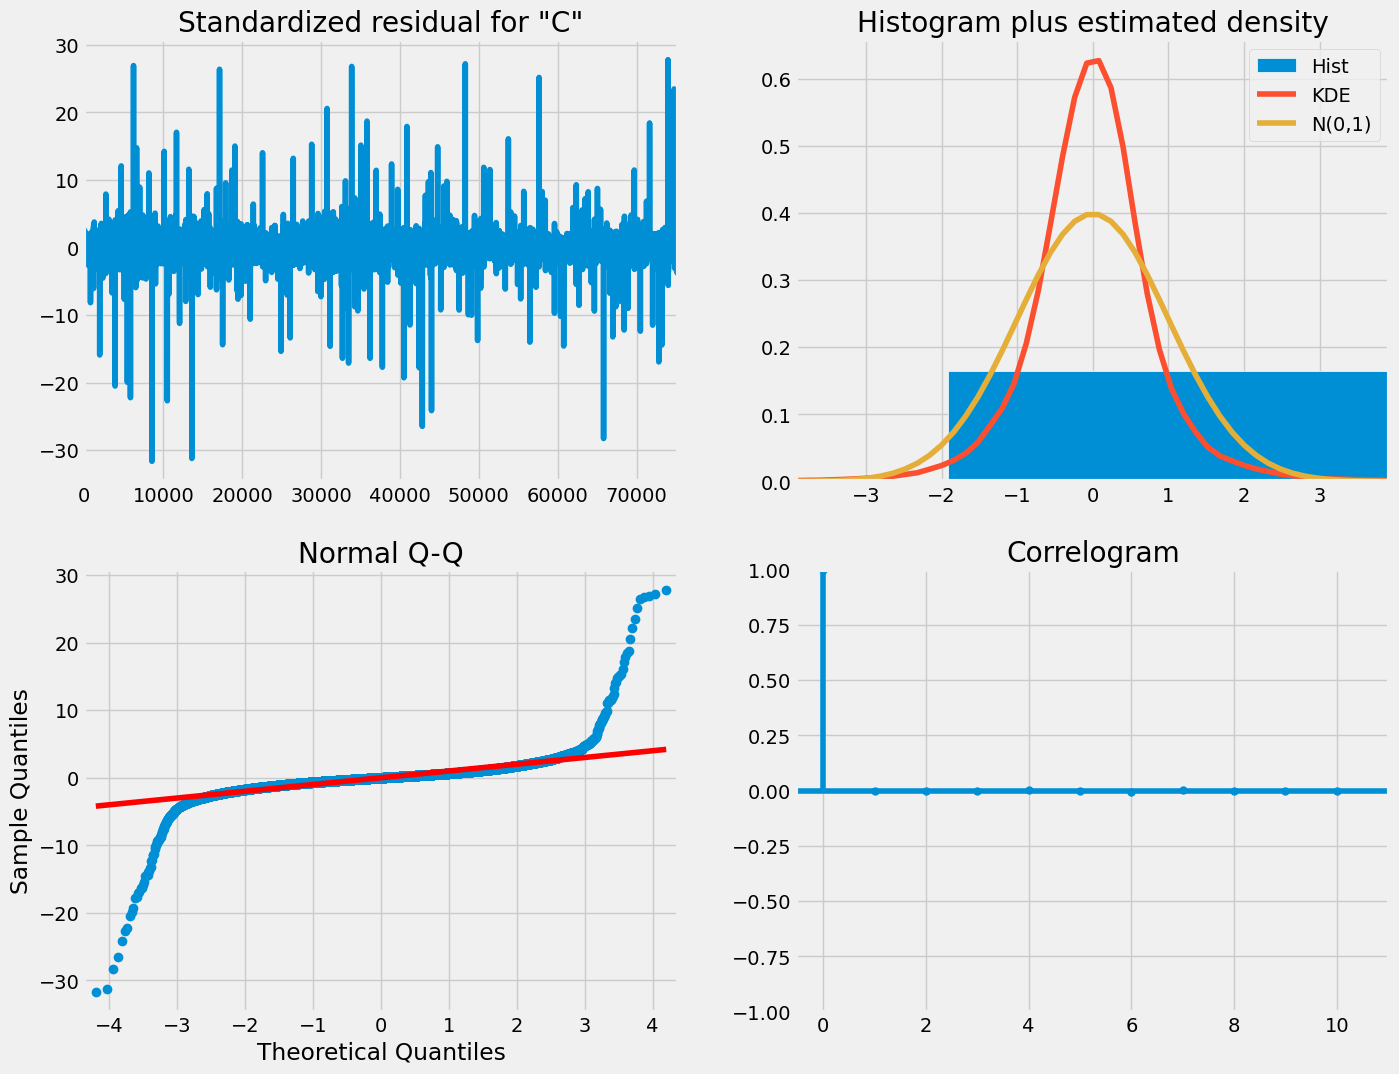

In [107]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [125]:
pred = results.get_prediction(start=len(train), end=len(raw_signal_df), dynamic=False)
pred_ci = pred.conf_int()

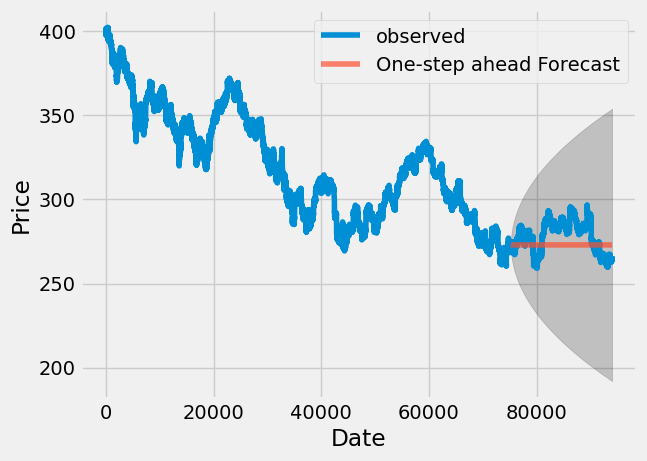

In [126]:
ax = raw_signal_df[sig_col].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()

plt.show()